# Visual Baseline model training (OverSampler, cosine scheduling, BCE loss):

In [2]:
import sys
root = '../../'
sys.path.append(root)   # Done to be able to import the packages and functions

import Utils.hico_evaluation.evaluation as ev
from Utils.custom_sampler import OverSampler
from Utils.custom_loss import MaskedBCELoss
from Utils.annotation_preprocessing import _load_csv_to_tensor
from Utils.train_val_split import train_val_split_hico
from hoi_classifiers import FeedForwardNetwork

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import random

In [3]:
seed = 42   #note that the model parameters will still be randomly initiated
torch.manual_seed(seed)
random.seed(seed)

### Loading the training set:


In [4]:
# Loading the data:
train_data = torch.load(root + "Embeddings/hico_train_center_crop.pt")
train_annotations = _load_csv_to_tensor(root + "anno/added/anno_augmented_train.csv").T # Transpose to make both first dimensions the #samples.
train_annotations[train_annotations.isnan()] = -1

##### Splitting the training set into a train and validation set:

In [5]:
train_idx, validation_idx = train_val_split_hico(train_data, train_annotations, 0.2, seed)
X_train, X_val = train_data[train_idx], train_data[validation_idx]
y_train, y_val = train_annotations[train_idx], train_annotations[validation_idx]

### Looking into the class distribution of the training data (before the split):

In [6]:
class_distribution = torch.sum((train_annotations[:,:600] == 1).int(),dim=0)

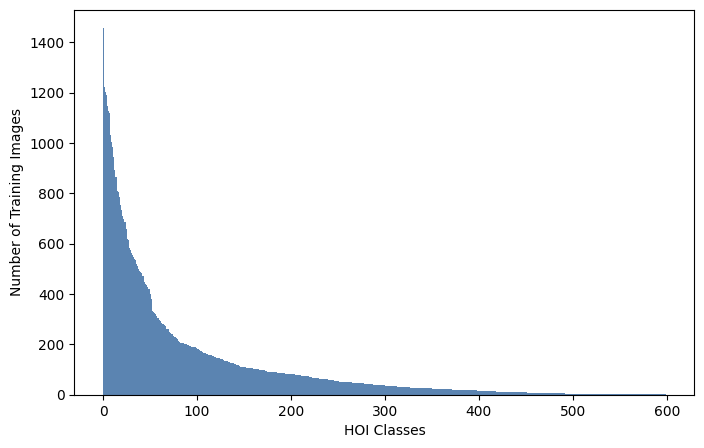

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(range(600),sorted(class_distribution, reverse=True),width=1, color='#5B84B1FF')
plt.xlabel('HOI Classes')
plt.ylabel('Number of Training Images')
plt.plot()
plt.savefig('lol.pdf')

<Figure size 640x480 with 0 Axes>

#### Training Preparations:

In [7]:
train_dataset = TensorDataset(X_train, y_train)

In [8]:
# Batch size:
bs = 512

sampler = OverSampler(y_train[:,:600], shuffle=True)

train_dataloader = DataLoader(
    train_dataset, batch_size=bs, num_workers=4, sampler=sampler)


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
model = FeedForwardNetwork(512, 655, 797)
model = model.to(device)

In [11]:
classweights = torch.cat((torch.ones(600),torch.ones(197)*0.5)).to(device)      # The hoi classes weigh twice as much as the seperate classes
criterion = MaskedBCELoss(ignore_label=0, convert_target_to_01= True, weight=classweights)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

c:\Users\rfigg\.conda\envs\PyTorch\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


#### Training loop:

In [12]:
num_epochs = 200
training_loss_per_epoch = np.zeros(200)
validation_loss_per_epoch = np.zeros(200)
validation_map_per_epoch = np.zeros(200)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item()

    scheduler.step()
    
    with torch.no_grad():
        pred = model.forward(X_val.to(device))
        # calculate the validation loss:
        validation_loss = criterion(pred, y_val.to(device))
        # calculate the validation mAP:
        validation_aps = ev.eval_vo(pred[:,:600].T.cpu().detach().numpy(), y_val[:,:600].T.numpy(),600)[0]
        nr_val_classes = np.sum(validation_aps != None) # because for the validation set not all 600 classes are present
        validation_map = np.nansum(validation_aps) / nr_val_classes

    # add the losses and mAP to the arrays:
    training_loss_per_epoch[epoch] = running_loss / len(train_dataloader)
    validation_loss_per_epoch[epoch] = validation_loss
    validation_map_per_epoch[epoch] = validation_map

    print(f"Epoch {epoch+1:0{len(str(num_epochs))}}/{num_epochs}, Loss: {running_loss/len(train_dataloader):.12f}, validation map: {validation_map:.12f}")

Epoch 001/200, Loss: 0.107774304728, validation map: 0.007856350595
Epoch 002/200, Loss: 0.021327915148, validation map: 0.038014479459
Epoch 003/200, Loss: 0.017958033137, validation map: 0.066353222772
Epoch 004/200, Loss: 0.016112396720, validation map: 0.079002810633
Epoch 005/200, Loss: 0.015393961543, validation map: 0.082418465683
Epoch 006/200, Loss: 0.014096126450, validation map: 0.120552605806
Epoch 007/200, Loss: 0.012233661715, validation map: 0.156883592106
Epoch 008/200, Loss: 0.011094318882, validation map: 0.181501011605
Epoch 009/200, Loss: 0.010469895680, validation map: 0.192797066385
Epoch 010/200, Loss: 0.010214216076, validation map: 0.196153923599
Epoch 011/200, Loss: 0.009770377778, validation map: 0.225813107418
Epoch 012/200, Loss: 0.009018160033, validation map: 0.247985180304
Epoch 013/200, Loss: 0.008514927211, validation map: 0.262879066457
Epoch 014/200, Loss: 0.008228181020, validation map: 0.270314842645
Epoch 015/200, Loss: 0.008100632023, validation 

### plotting the training process to select the number of convergence

[]

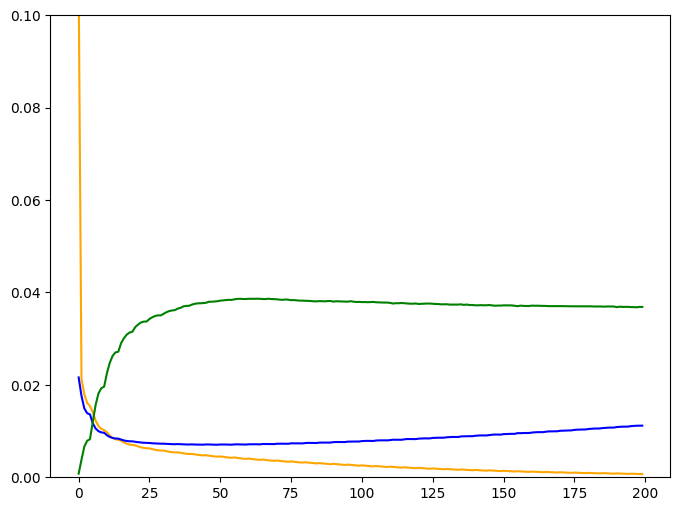

In [13]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(200), training_loss_per_epoch, color = "orange")
plt.plot(np.arange(200), validation_loss_per_epoch, color = "blue")
# plt.plot(np.arange(100), validation_loss_main_per_epoch, color= "red")
# plt.plot(np.arange(100), validation_loss_side_per_epoch, color = "purple")
plt.plot(np.arange(200), validation_map_per_epoch/10, color = "green")
#plt.hlines(0.010051161982119083, 0, 100 , colors=['black'],linestyles=['dotted'])
plt.ylim(0,0.1)
plt.plot()

In [14]:
np.argmax(validation_map_per_epoch)

67

In [15]:
np.argmin(validation_loss_per_epoch)

49